# FF->PC 10-5-3
**Purpose:**

To see if FF weights can be used in a PC network, but on a simple, Gaussian dataset.

**What I learned:**
- Yes, FF weights work for a PC network in discriminative mode
- Adding weight decay to FF training allows the PC net to be generative, but only if the PC network also has value decay.

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
import NeuralNetwork as NN
import FFNetwork as FF
import Layer
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(FF)
importlib.reload(Layer);

In [2]:
def FF2PC(net):
    '''
     pcnet = FF2PC(ffnet)
     
     Creates a Predictive Coding (PC) network that parallels the given
     Feedforward network.
     
     Inputs:
       ffnet is a feedforward network
       
     Output:
       pcnet is a PC network that mirrors the architecture of ffnet,
             and uses the same weight matrices.
    '''
    pcnet = NN.NeuralNetwork()
    MtoW_factor = 1.
    sym = False
    n_classes = net.lyr[-1].N
    sensory_dim = net.lyr[0].N
    pcnet.AddLayer(Layer.InputPELayer(n=n_classes))
    rng = np.arange(len(net.lyr)-2, 0, -1, dtype=int)
    for k,ff_idx in enumerate(rng):
        pc_idx = k+1
        l = net.lyr[ff_idx]
        print('FF layer '+str(ff_idx)+' is PC layer '+str(pc_idx))
        pcnet.AddLayer(Layer.PELayer(n=l.N))
        print(pc_idx-1, pc_idx)
        pcnet.Connect(pc_idx-1, pc_idx, act=l.act_text, symmetric=sym)
        pcnet.connections[k].SetM(net.W[ff_idx])
        pcnet.connections[k].SetW(net.W[ff_idx].T*MtoW_factor)
        pcnet.layers[pc_idx].SetBias(net.lyr[ff_idx].b)
    pcnet.AddLayer(Layer.TopPELayer(n=sensory_dim))
    print(pc_idx, pc_idx+1)
    pcnet.Connect(pc_idx, pc_idx+1, act='identity', symmetric=sym)
    pcnet.connections[-1].SetM(net.W[0])
    pcnet.connections[-1].SetW(net.W[0].T*MtoW_factor)
    pcnet.layers[pc_idx].SetBias(net.lyr[ff_idx].b)

    pcnet.SetTau(0.02)
    pcnet.learning_tau = 0.1
    pcnet.learn_biases = False
    pcnet.learning_blackout=2.0
    return pcnet

In [3]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

In [4]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2, seed=None):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    if seed:
        np.random.seed(seed)
    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

## Create a simple dataset

In [5]:
# 10-5-3
n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 22861
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[-0.464102    1.13510861  0.27987809 -0.80952547 -0.62742824  0.88189414
  -1.06856969 -0.12029622 -1.28758735 -0.75712289]
 [-0.43072252 -1.04548577  0.29242776 -0.76850641  0.85452668 -0.38805579
  -0.46959364 -0.84681723 -0.40557881 -0.66455909]
 [-0.74201633  0.84413599  1.42240057  0.02607347 -1.01869114  0.25278516
   1.07382475 -0.20503778 -1.28384522  0.515034  ]]


In [6]:
train = MakeDataset(A, B, noise=0.2, seed=9)

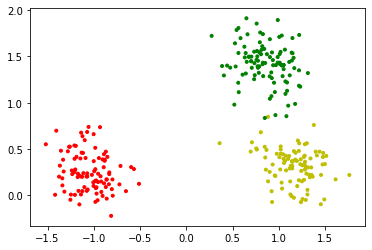

In [7]:
plot_idx = (1,2)
ClassPlot(train[1], labels=train[0], idx=plot_idx)

## Train Feedforward Network

In [8]:
lr = 0.01   # learning rate
Wdecay = 0.07  # weight decay
af = 'identity'
mid_af = 'logistic'

In [9]:
# Create a FF network for normal training
ffnet = FF.Network()
ffnet.AddLayer(FF.Layer(n_nodes=sensory_dim, act=af))
ffnet.AddLayer(FF.Layer(n_nodes=hidden_dim, act=mid_af))
ffnet.AddLayer(FF.Layer(n_nodes=n_classes, act=af))
ffnet.SetCostFunction('MSE')

In [10]:
# Create a FF network for training with decay
ffdnet = FF.Network()
ffdnet.AddLayer(FF.Layer(n_nodes=sensory_dim, act=af))
ffdnet.AddLayer(FF.Layer(n_nodes=hidden_dim, act=mid_af))
ffdnet.AddLayer(FF.Layer(n_nodes=n_classes, act=af))
ffdnet.SetCostFunction('MSE')

In [11]:
progress = ffnet.SGD(train[1].numpy(), train[0].numpy(), lrate=lr, epochs=500, batch_size=30,
                     decay=0., progress=100)

Epoch 100: Cost = 0.04296271647437872
Epoch 200: Cost = 0.014531761102415199
Epoch 300: Cost = 0.010614485174890347
Epoch 400: Cost = 0.009676539906824152


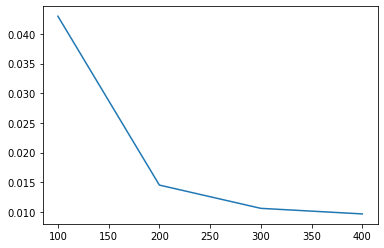

In [12]:
plt.plot(progress[:,0], progress[:,1]);

In [13]:
progress = ffdnet.SGD(train[1].numpy(), train[0].numpy(), lrate=lr, epochs=500, batch_size=30,
                      decay=lr*Wdecay, progress=100)

Epoch 100: Cost = 0.11296360192863868
Epoch 200: Cost = 0.08076317693766183
Epoch 300: Cost = 0.07600398818128426
Epoch 400: Cost = 0.07445250514126836


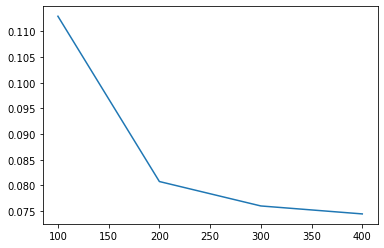

In [14]:
plt.plot(progress[:,0], progress[:,1]);

In [15]:
FF.ClassificationAccuracy(ffnet.FeedForward(train[1].numpy()), train[0].numpy())

1.0

In [16]:
FF.ClassificationAccuracy(ffdnet.FeedForward(train[1].numpy()), train[0].numpy())

1.0

## Create PC network by copying FF weights -> `netFF`

In [17]:
# PC net from FF weights trained WITHOUT weight decay
pcnet = FF2PC(ffnet)

FF layer 1 is PC layer 1
0 1
logistic
1 2
identity


In [18]:
# PC net from FF weights trained WITH weight decay
pcdnet = FF2PC(ffdnet)

FF layer 1 is PC layer 1
0 1
logistic
1 2
identity


## PC in Discriminative Mode

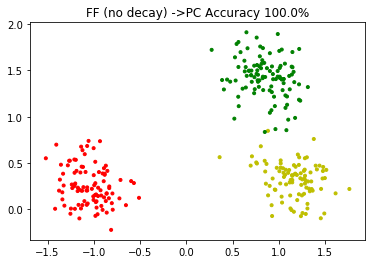

In [19]:
mu0 = pcnet.Generate(5., train[1], dt=0.001)
acc = FF.ClassificationAccuracy(NN.logistic(mu0).numpy(), train[0].numpy())
ClassPlot(train[1], labels=pcnet.connections[0].sigma(mu0), idx=plot_idx);
plt.title('FF (no decay) ->PC Accuracy '+str(acc*100)+'%');

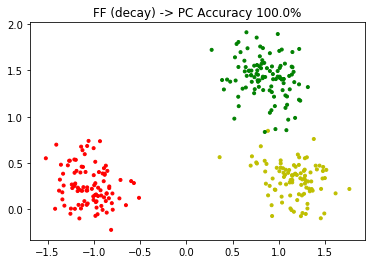

In [20]:
mu0 = pcdnet.Generate(5., train[1], dt=0.001)
acc = FF.ClassificationAccuracy(NN.logistic(mu0).numpy(), train[0].numpy())
ClassPlot(train[1], labels=pcnet.connections[0].sigma(mu0), idx=plot_idx);
plt.title('FF (decay) -> PC Accuracy '+str(acc*100)+'%');

## PC in Generative Mode

### Make a set of inputs

In [21]:
#ins = torch.tensor(deepcopy(mu0.numpy()[:20]))

In [22]:
e3 = torch.eye(3)
ins = torch.cat((e3,e3,e3,e3,e3), 0)
print(ins)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


### Trained WITHOUT weight decay

In [29]:
netx = pcnet
netx.Reset(random=2.)
netx.SetvDecay(0.0)
v0 = netx.Predict(5., ins, dt=0.001, random=2.)

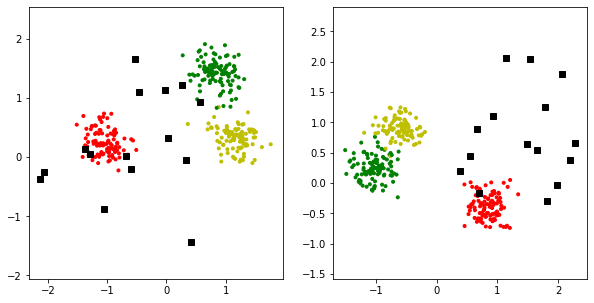

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1);
ClassPlot(train[1], labels=train[0], idx=plot_idx)
plt.plot(np.array(v0[:,plot_idx[0]]), np.array(v0[:,plot_idx[1]]), 'ks');
plt.subplot(1,2,2); plot_idx2 = (4,5)
ClassPlot(train[1], labels=train[0], idx=plot_idx2)
plt.plot(np.array(v0[:,plot_idx2[0]]), np.array(v0[:,plot_idx2[1]]), 'ks');

### Trained WITH weight decay

#### Generative Mode Without Activity Decay

In [31]:
netx = pcdnet
netx.Reset(random=2.)
netx.SetvDecay(0.0)
v0 = netx.Predict(5., ins, dt=0.001, random=2.)

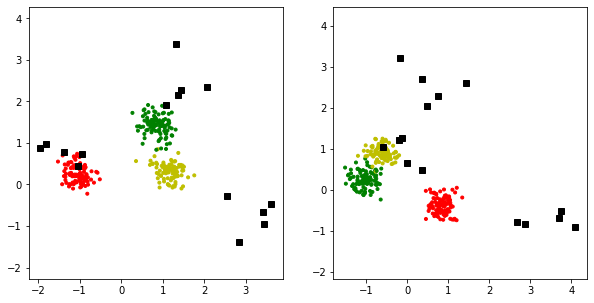

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1);
ClassPlot(train[1], labels=train[0], idx=plot_idx)
plt.plot(np.array(v0[:,plot_idx[0]]), np.array(v0[:,plot_idx[1]]), 'ks');
plt.subplot(1,2,2); plot_idx2 = (4,5)
ClassPlot(train[1], labels=train[0], idx=plot_idx2)
plt.plot(np.array(v0[:,plot_idx2[0]]), np.array(v0[:,plot_idx2[1]]), 'ks');

#### Generative Mode WITH Activity Decay

In [39]:
netx = pcdnet
netx.Reset(random=2.)
netx.SetvDecay(0.01)
v0 = netx.Predict(5., ins, dt=0.001, random=2.)

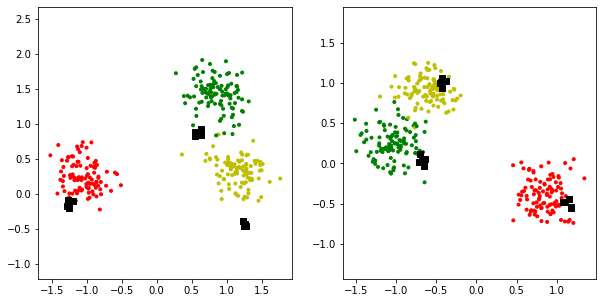

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1);
ClassPlot(train[1], labels=train[0], idx=plot_idx)
plt.plot(np.array(v0[:,plot_idx[0]]), np.array(v0[:,plot_idx[1]]), 'ks');
plt.subplot(1,2,2); plot_idx2 = (4,5)
ClassPlot(train[1], labels=train[0], idx=plot_idx2)
plt.plot(np.array(v0[:,plot_idx2[0]]), np.array(v0[:,plot_idx2[1]]), 'ks');